# Final model evaluation

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, recall_score
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
# Load dataset
data = pd.read_csv("../data/processed/fraud.csv")

X = data.drop(columns=['FraudFound_P','Make_frequency_encoded'])
y = data['FraudFound_P'].astype(int)

# Split 
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 9252, Val: 3084, Test: 3084


In [41]:
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
import lightgbm as lgb

# Defining the Tuned LightGBM classifier with parameters
lgb_clf = lgb.LGBMClassifier(
    random_state=42,
    learning_rate=0.1,
    max_depth=-1,
    min_child_samples=50,
    n_estimators=500,
    num_leaves=31,
    verbose=-1
)

# Building the pipeline with SMOTEENN and LightGBM
tuned_lgb = Pipeline([
    ('smoteenn', SMOTEENN(random_state=42)),
    ('lgb', lgb_clf)
])




Number of selected features: 20
Number of dropped features: 23
Selected features: ['PolicyNumber', 'Age', 'RepNumber', 'Month', 'Make_label_encoded', 'MonthClaimed', 'DayOfWeek', 'DayOfWeekClaimed', 'AgeVehicleRatio', 'WeekOfMonth', 'DriverRating', 'NumberOfSuppliments', 'WeekOfMonthClaimed', 'VehiclePrice', 'PastNumberOfClaims', 'BasePolicy', 'AgeOfVehicle', 'AddressChange_Claim', 'Fault', 'Deductible']
Dropped features: ['AccidentArea', 'Sex', 'MaritalStatus', 'VehicleCategory', 'Days_Policy_Accident', 'Days_Policy_Claim', 'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType', 'NumberOfCars', 'Year', 'DaysToClaimRatio', 'IsYoungDriver', 'IsOldVehicle', 'QuickClaim', 'NoPoliceReport', 'NoWitness', 'IsNewPolicy', 'HighDeductible', 'IsFrequentClaimant', 'AddressChanged', 'RiskScore']


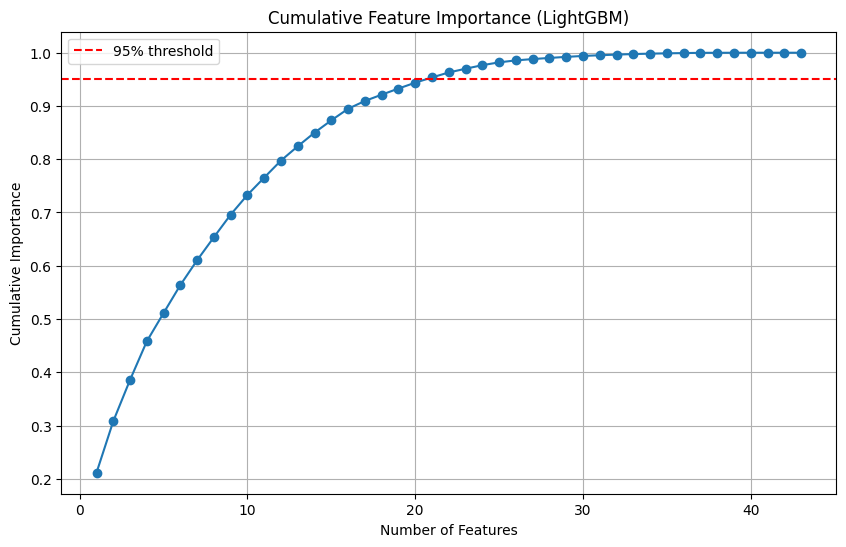

In [42]:
# Feature selection
lgb_clf_fs = lgb.LGBMClassifier(random_state=42, n_estimators=500, verbose=-1)
lgb_clf_fs.fit(X_train, y_train)

importances = pd.Series(lgb_clf_fs.feature_importances_, index=X_train.columns)
importances_sorted = importances.sort_values(ascending=False)
cumulative_importance = importances_sorted.cumsum() / importances_sorted.sum()

selected_features = cumulative_importance[cumulative_importance <= 0.95].index.tolist()
dropped_features = [f for f in X_train.columns if f not in selected_features]

print(f"Number of selected features: {len(selected_features)}")
print(f"Number of dropped features: {len(dropped_features)}")
print("Selected features:", selected_features)
print("Dropped features:", dropped_features)

plt.figure(figsize=(10,6))
plt.plot(range(1, len(cumulative_importance)+1), cumulative_importance.values, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
plt.title("Cumulative Feature Importance (LightGBM)")
plt.xlabel("Number of Features")
plt.ylabel("Cumulative Importance")
plt.legend()
plt.grid(True)
plt.show()

Below, we train the final tuned LightGBM model using the selected features. The training and validation sets are combined to form the full training data, allowing the model to learn from all available labeled samples before final evaluation.
The model is then evaluated on the untouched test set to obtain unbiased performance metrics.

In [43]:
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, auc
)

X_full_train = pd.concat([X_train[selected_features], X_val[selected_features]])
y_full_train = pd.concat([y_train, y_val])

print("Full training data shape:", X_full_train.shape)
print("Test data shape:", X_test[selected_features].shape)

tuned_lgb.fit(X_full_train, y_full_train)

# Evaluate on test set
X_test_selected = X_test[selected_features]
y_test_pred = tuned_lgb.predict(X_test_selected)
y_test_prob = tuned_lgb.predict_proba(X_test_selected)[:, 1]

print("\nFinal Test Set Evaluation")
print("Classification Report:")
print(classification_report(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_prob))
prec_curve, rec_curve, _ = precision_recall_curve(y_test, y_test_prob)
pr_auc = auc(rec_curve, prec_curve)
print("PR-AUC:", pr_auc)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


Full training data shape: (12336, 20)
Test data shape: (3084, 20)

Final Test Set Evaluation
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2899
           1       0.57      0.70      0.63       185

    accuracy                           0.95      3084
   macro avg       0.77      0.83      0.80      3084
weighted avg       0.96      0.95      0.95      3084

ROC-AUC: 0.9660665840038039
PR-AUC: 0.6498974767282737
Confusion Matrix:
 [[2801   98]
 [  56  129]]


In [44]:
X_test_selected.columns

Index(['PolicyNumber', 'Age', 'RepNumber', 'Month', 'Make_label_encoded',
       'MonthClaimed', 'DayOfWeek', 'DayOfWeekClaimed', 'AgeVehicleRatio',
       'WeekOfMonth', 'DriverRating', 'NumberOfSuppliments',
       'WeekOfMonthClaimed', 'VehiclePrice', 'PastNumberOfClaims',
       'BasePolicy', 'AgeOfVehicle', 'AddressChange_Claim', 'Fault',
       'Deductible'],
      dtype='object')

In [45]:
import pickle

In [46]:
with open("../models/model.pkl", "wb") as model_file:
    pickle.dump(tuned_lgb, model_file)

# Model Explainability (Using SHAP)

In [47]:
import shap
shap.initjs()

In [48]:
# Extract trained LightGBM model from pipeline
lgb_model = tuned_lgb.named_steps['lgb']

# Create SHAP explainer using training data
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test_selected)


c:\Users\En Xin\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


## Barplot and Beeswarm plot

Here, we find out which features are most influential in our prediction (Barplot), and how each feature influences fraud prediction (Beeswarm plot).

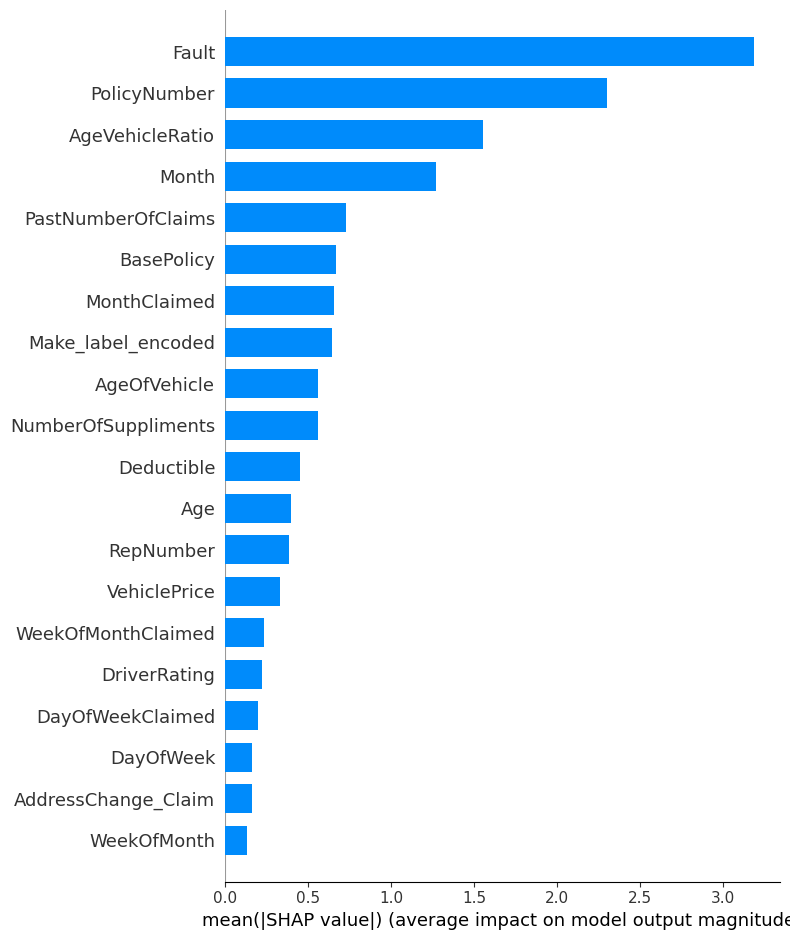

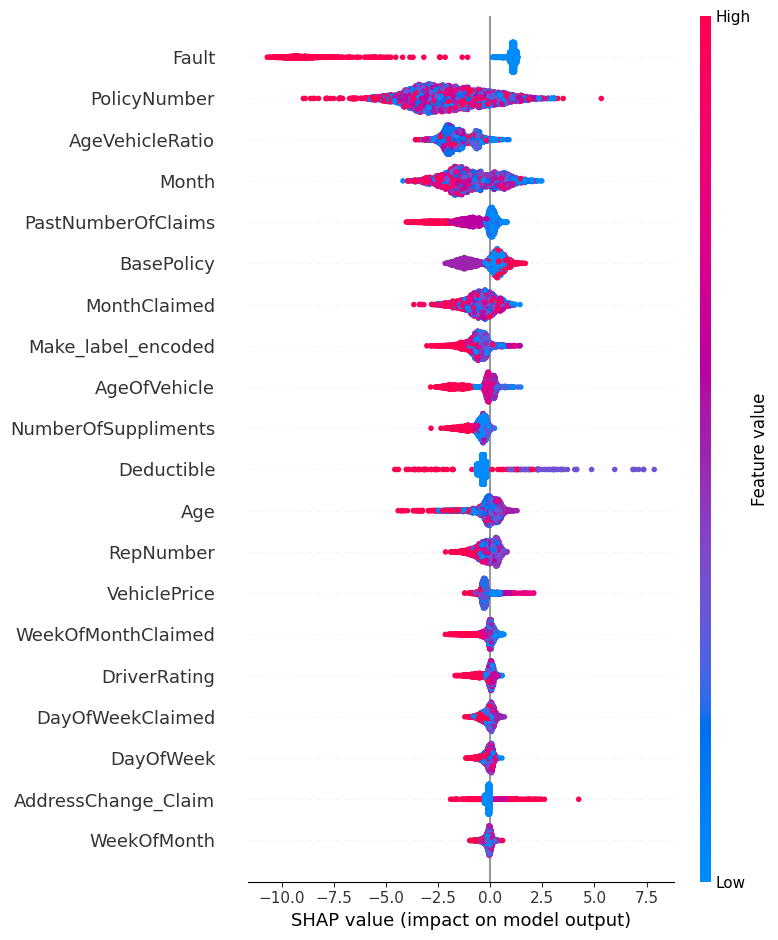

In [49]:
# Summary plot (feature impact across all test samples)
shap.summary_plot(shap_values, X_test_selected, plot_type="bar")

# Detailed summary with distribution of SHAP values
shap.summary_plot(shap_values, X_test_selected)


## SHAP force plot

In [50]:
i = 1501 # example index
shap.force_plot(
    explainer.expected_value, 
    shap_values[i, :], 
    X_test_selected.iloc[i]
)

## Partial Dependence Plots (PDP)

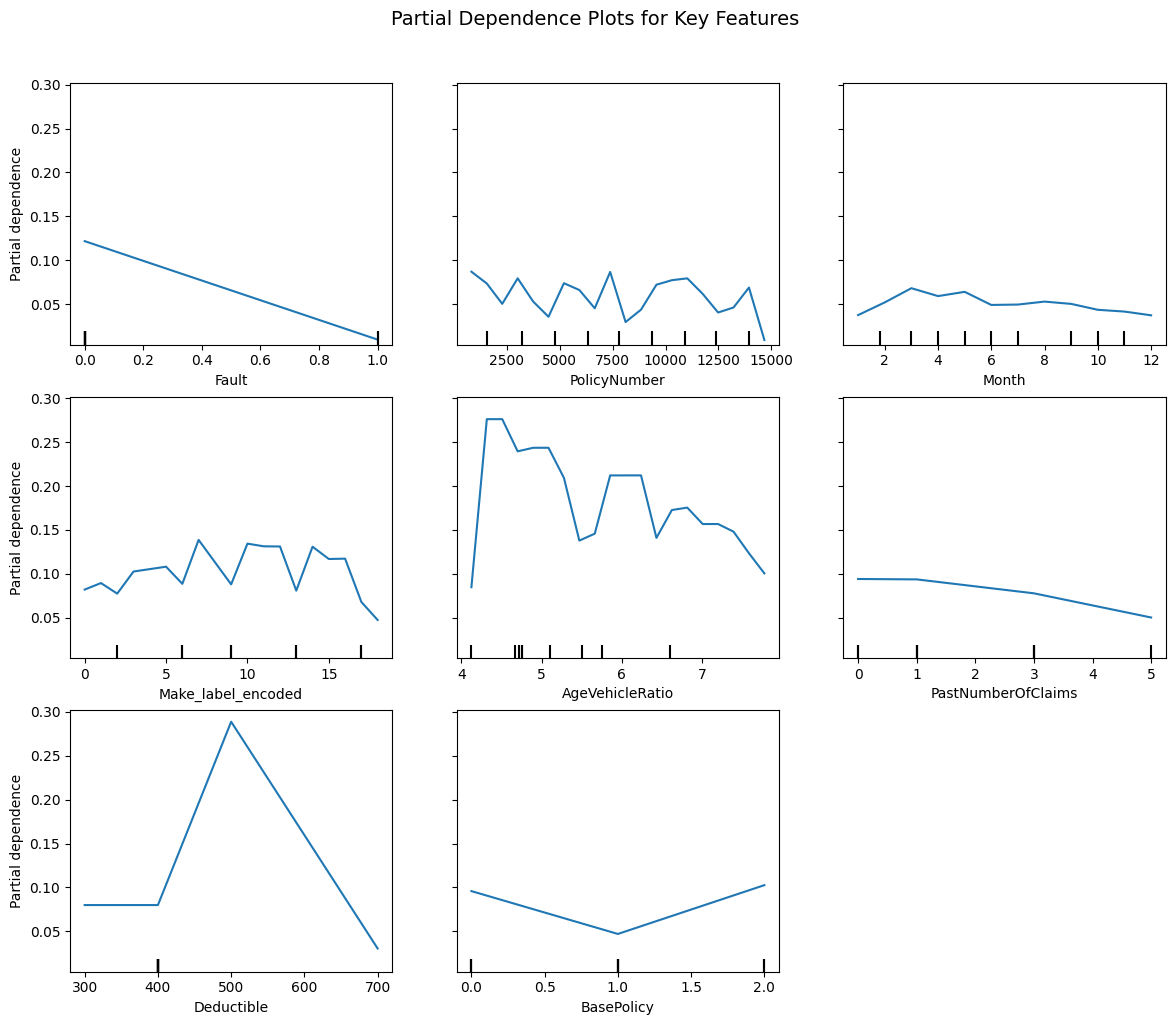

In [51]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

X_test_selected = X_test_selected.astype(float)

fig, ax = plt.subplots(figsize=(12, 10)) 

PartialDependenceDisplay.from_estimator(
    lgb_model,
    X_test_selected,
    features=[
        'Fault', 'PolicyNumber', 'Month', 'Make_label_encoded',
        'AgeVehicleRatio', 'PastNumberOfClaims', 'Deductible', 'BasePolicy'
    ],
    grid_resolution=20,
    ax=ax
)

plt.suptitle("Partial Dependence Plots for Key Features", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


# Fairness Testing

In [52]:
# Prepare the data
fairness_df = X_test_selected.reset_index(drop=True).copy()
fairness_df['y_true'] = y_test.values
fairness_df['y_pred_prob'] = y_test_prob
fairness_df['y_pred'] = y_test_pred

In [53]:
# Split Age into Age_group
def age_to_group(age):
    if age < 40:
        return "Young(<40)"
    elif age <= 60:
        return "Middle(40-60)"
    else:
        return "Old(>60)"

fairness_df["Age_group"] = fairness_df["Age"].apply(age_to_group)

# Sort the age group
fairness_df["Age_group"] = pd.Categorical(
    fairness_df["Age_group"],
    categories = ["Young(<40)", "Middle(40-60)", "Old(>60)"],
    ordered=True
)
fairness_df = fairness_df.sort_values('Age_group')

## Equalized Odds (TPR & FPR)

In [54]:
# Function to compute TPR and FPR using confusion_matrix
def compute_tpr_fpr(df, col):
    metrics = []
    groups = df[col].unique()
    
    for g in groups:
        group = df[df[col] == g]
        tn, fp, fn, tp = confusion_matrix(group['y_true'], group['y_pred']).ravel()
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        pos = tp + fn
        neg = tn + fp

        metrics.append({
            col: g,
            'TPR': tpr,
            'FPR': fpr,
            'Positives': pos,
            'Negatives': neg
        })
        
    return pd.DataFrame(metrics)

def plot_fairness(df, group_col, title):
    # melt to long format
    melted = df.melt(
        id_vars=group_col,
        value_vars=['TPR', 'FPR'],
        var_name='Metric',
        value_name='Rate'
    )

    plt.figure(figsize=(7, 5))
    sns.barplot(data=melted, x=group_col, y='Rate', hue='Metric')
    plt.title(title)
    plt.ylim(0, 1)
    plt.xlabel("")
    plt.tight_layout()
    plt.show()


In [55]:
df_eo = compute_tpr_fpr(fairness_df, 'Age_group')
df_eo

,Age_group,TPR,FPR,Positives,Negatives
0,Young(<40),0.763158,0.036387,114,1539
1,Middle(40-60),0.622951,0.034211,61,1140
2,Old(>60),0.400000,0.013636,10,220


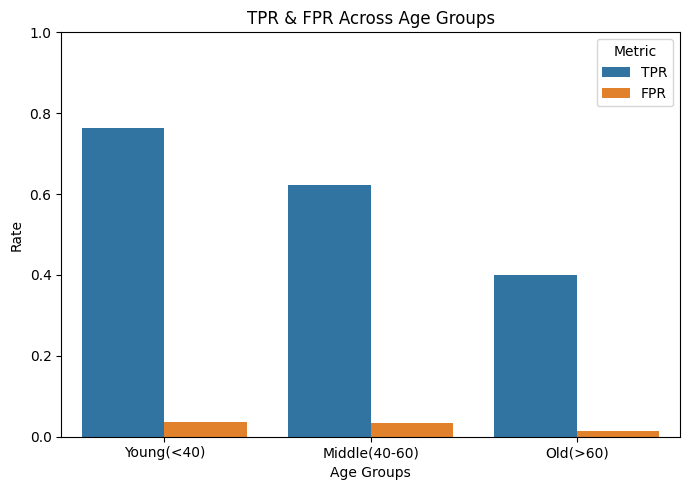

In [56]:
# melt to long format
df_eo = df_eo.melt(
    id_vars='Age_group', value_vars=['TPR', 'FPR'], var_name='Metric', value_name='Rate')

# Plot
plt.figure(figsize=(7, 5))
sns.barplot(data=df_eo, x='Age_group', y='Rate', hue='Metric')
plt.title('TPR & FPR Across Age Groups')
plt.ylim(0, 1)
plt.xlabel("Age Groups")
plt.tight_layout()
plt.show()


## SHAP Group Analysis

In [57]:
# Convert SHAP to DataFrame
shap_df = pd.DataFrame(shap_values, columns=X_test_selected.columns)

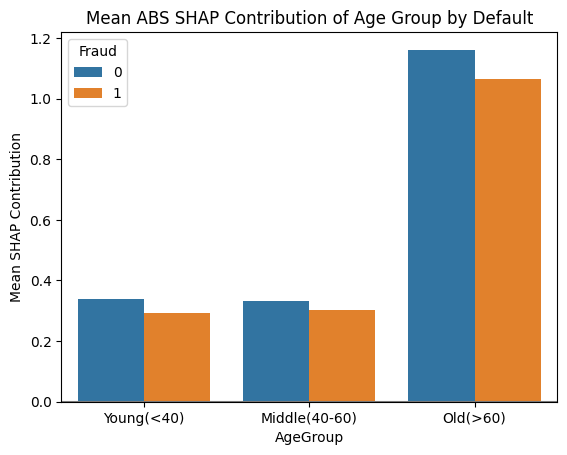

In [58]:
# SHAP contribution for Age Group
fairness_df['SHAP_age_abs'] = shap_df['Age'].abs()

sns.barplot(data=fairness_df, x='Age_group', y='SHAP_age_abs', hue='y_true', errorbar=None)
plt.title('Mean ABS SHAP Contribution of Age Group by Default')
plt.xlabel("AgeGroup")
plt.ylabel("Mean SHAP Contribution")
plt.legend(title='Fraud')
plt.axhline(y=0, color='Grey')
plt.show()